In [1]:
# Import the data!
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load all 5 coins ---
btc_data  = pd.read_csv("../historic_data/BTC_funding_data.csv",  parse_dates=["time"]).sort_values("time")
eth_data  = pd.read_csv("../historic_data/ETH_funding_data.csv",  parse_dates=["time"]).sort_values("time")
sol_data  = pd.read_csv("../historic_data/SOL_funding_data.csv",  parse_dates=["time"]).sort_values("time")
doge_data = pd.read_csv("../historic_data/DOGE_funding_data.csv", parse_dates=["time"]).sort_values("time")
kpepe_data= pd.read_csv("../historic_data/kPEPE_funding_data.csv",parse_dates=["time"]).sort_values("time")

In [2]:
n = 24 * 10  # 10 days ahead

# --- Target for all 5 coins ---
for df in (btc_data, eth_data, sol_data, doge_data, kpepe_data):
    df["future_funding_10d_mean"] = df["funding"].shift(-n).rolling(n, min_periods=n).mean()

# --- Drop NA for all 5 coins ---
btc_data   = btc_data.dropna()
eth_data   = eth_data.dropna()
sol_data   = sol_data.dropna()
doge_data  = doge_data.dropna()
kpepe_data = kpepe_data.dropna()

In [3]:
# --- Feature builder ---
n_2d, n_6d, n_18d = 24*2, 24*6, 24*18

def add_features(df):
    df = df.sort_values("time").copy()

    # Funding averages
    df["funding_avg_2d"]  = df["funding"].rolling(n_2d,  min_periods=n_2d).mean()
    df["funding_avg_6d"]  = df["funding"].rolling(n_6d,  min_periods=n_6d).mean()
    df["funding_avg_18d"] = df["funding"].rolling(n_18d, min_periods=n_18d).mean()

    # Premium averages
    df["premium_avg_2d"]  = df["premium"].rolling(n_2d,  min_periods=n_2d).mean()
    df["premium_avg_6d"]  = df["premium"].rolling(n_6d,  min_periods=n_6d).mean()
    df["premium_avg_18d"] = df["premium"].rolling(n_18d, min_periods=n_18d).mean()

    # Open interest averages
    # df["oi_avg_2d"]  = df["open_interest"].rolling(n_2d,  min_periods=n_2d).mean()
    # df["oi_avg_6d"]  = df["open_interest"].rolling(n_6d,  min_periods=n_6d).mean()
    # df["oi_avg_18d"] = df["open_interest"].rolling(n_18d, min_periods=n_18d).mean()

    return df

btc_data = add_features(btc_data)
eth_data = add_features(eth_data)
sol_data = add_features(sol_data)
doge_data = add_features(doge_data)
kpepe_data = add_features(kpepe_data)


In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


# Features / Target
featureCols = [
    "funding_avg_2d", "funding_avg_6d", "funding_avg_18d",
    "premium_avg_2d", "premium_avg_6d", "premium_avg_18d",
    # "oi_avg_2d", "oi_avg_6d", "oi_avg_18d",
]
targetCol = "future_funding_10d_mean"

def cleanAndSplitCoin(dfCoin: pd.DataFrame, coinName: str):
    dfCoin = dfCoin.dropna(subset=featureCols + [targetCol]).sort_values("time").copy()
    dfCoin["coin"] = coinName

    n = len(dfCoin)
    if n < 10:
        raise ValueError(f"{coinName}: not enough rows ({n}) to split 70/15/15")

    n_train = int(round(n * 0.60))
    n_val   = int(round(n * 0.15))
    # ensure all rows used (put remainder in test)
    n_test  = n - n_train - n_val
    if n_test <= 0:
        raise ValueError(f"{coinName}: not enough rows for 15% test after rounding (n={n})")

    dfTrain = dfCoin.iloc[:n_train]
    dfVal   = dfCoin.iloc[n_train:n_train + n_val]
    dfTest  = dfCoin.iloc[n_train + n_val:]
    return dfTrain, dfVal, dfTest


def reportMetrics(splitName: str, yTrue, yPred):
    mse = mean_squared_error(yTrue, yPred)
    mae = mean_absolute_error(yTrue, yPred)
    r2 = r2_score(yTrue, yPred)
    print(f"{splitName} -> MSE: {mse:.8f} | MAE: {mae:.8f} | R^2: {r2:.4f} | "
          f"Mean(y): {np.mean(yTrue):.8f} | Mean(ŷ): {np.mean(yPred):.8f}")

# Per-coin splits (BTC/ETH/SOL must exist)
btcTrain, btcVal, btcTest = cleanAndSplitCoin(btc_data, "BTC")
ethTrain, ethVal, ethTest = cleanAndSplitCoin(eth_data, "ETH")
solTrain, solVal, solTest = cleanAndSplitCoin(sol_data, "SOL")
dogeTrain, dogeVal, dogeTest = cleanAndSplitCoin(doge_data, "DOGE")
kpepeTrain, kpepeVal, kpepeTest = cleanAndSplitCoin(kpepe_data, "kPEPE")

# Combine chronologically
trainAll = pd.concat([btcTrain,  ethTrain,  solTrain,  dogeTrain,  kpepeTrain], ignore_index=True).sort_values("time")
valAll   = pd.concat([btcVal,    ethVal,    solVal,    dogeVal,    kpepeVal  ], ignore_index=True).sort_values("time")
testAll  = pd.concat([btcTest,   ethTest,   solTest,   dogeTest,   kpepeTest ], ignore_index=True).sort_values("time")


# Coin dummies (align across splits)
d_train = pd.get_dummies(trainAll["coin"], prefix="coin", drop_first=False)
d_val   = pd.get_dummies(valAll["coin"],   prefix="coin", drop_first=False)
d_test  = pd.get_dummies(testAll["coin"],  prefix="coin", drop_first=False)
all_cols = sorted(set(d_train.columns) | set(d_val.columns) | set(d_test.columns))
d_train = d_train.reindex(columns=all_cols, fill_value=0)
d_val   = d_val.reindex(columns=all_cols,   fill_value=0)
d_test  = d_test.reindex(columns=all_cols,  fill_value=0)

trainAll = pd.concat([trainAll.reset_index(drop=True), d_train.reset_index(drop=True)], axis=1)
valAll   = pd.concat([valAll.reset_index(drop=True),   d_val.reset_index(drop=True)],   axis=1)
testAll  = pd.concat([testAll.reset_index(drop=True),  d_test.reset_index(drop=True)],  axis=1)

featureCols = list(featureCols) + all_cols

# ---------- Single validation set (no blocks) ----------
# X/y
XTrain, yTrain = trainAll[featureCols], trainAll[targetCol]
XVal,   yVal   = valAll[featureCols],   valAll[targetCol]
XTest,  yTest  = testAll[featureCols],  testAll[targetCol]

# Scale (fit on train only)
scaler = StandardScaler()
XTrainScaled = scaler.fit_transform(XTrain)
XValScaled   = scaler.transform(XVal)
XTestScaled  = scaler.transform(XTest)

In [5]:
# ---------- Probe + staged early stopping on the single val set ----------

probe = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.8,
    random_state=42
).fit(XTrainScaled, yTrain)

bestIter = 1
bestMae  = float("inf")
bestMse  = float("inf")

for i, yHat in enumerate(probe.staged_predict(XValScaled), start=1):
    mae = mean_absolute_error(yVal, yHat)
    mse = mean_squared_error(yVal, yHat)
    if mae < bestMae:
        bestMae, bestMse, bestIter = mae, mse, i
    if i % 100 == 0 or i == 1:
        print(f"Iter {i:4d}: MAE={mae:.6f} | MSE={mse:.8f}")

print(f"\n[Early Stopping] Best nEstimators: {bestIter}")
print(f"  Val MAE: {bestMae:.6f}")
print(f"  Val MSE: {bestMse:.8f}")

Iter    1: MAE=0.000021 | MSE=0.00000000
Iter  100: MAE=0.000015 | MSE=0.00000000
Iter  200: MAE=0.000015 | MSE=0.00000000
Iter  300: MAE=0.000015 | MSE=0.00000000
Iter  400: MAE=0.000015 | MSE=0.00000000
Iter  500: MAE=0.000015 | MSE=0.00000000
Iter  600: MAE=0.000015 | MSE=0.00000000

[Early Stopping] Best nEstimators: 144
  Val MAE: 0.000015
  Val MSE: 0.00000000


In [6]:
# Refit on Train + ALL Validation; evaluate on Test
XTrVal = pd.concat([trainAll[featureCols], valAll[featureCols]], ignore_index=True)
yTrVal = pd.concat(
    [trainAll[[targetCol]], valAll[[targetCol]]],
    ignore_index=True
)[targetCol]

scalerFinal = StandardScaler()
XTrValScaled = scalerFinal.fit_transform(XTrVal)
XTestScaledFinal = scalerFinal.transform(testAll[featureCols])

finalModel = GradientBoostingRegressor(
    n_estimators=max(1, bestIter),
    learning_rate=0.02,
    max_depth=2,
    subsample=0.8,
    random_state=42,
).fit(XTrValScaled, yTrVal)

# Combined test (keeps your current prints)
yTestPred = finalModel.predict(XTestScaledFinal)
reportMetrics("TEST (combined)", testAll[targetCol].values, yTestPred)
print(
    f"TEST DirAcc: "
    f"{float(np.mean(np.sign(testAll[targetCol].values) == np.sign(yTestPred))):.3f}"
)

# === Per-coin metrics ===
coin_order = ["BTC", "ETH", "SOL", "DOGE", "kPEPE"]

print("\n=== Test RMSE per coin (original units) ===")
for sym in coin_order:
    dfc = testAll[testAll["coin"] == sym]
    if len(dfc) == 0:
        continue

    Xc_scaled = scalerFinal.transform(dfc[featureCols])
    y_true = dfc[targetCol].values
    y_pred = finalModel.predict(Xc_scaled)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{sym}: {rmse:.6e}")

print("\n=== Test Directional Accuracy per coin (sign vs 0) ===")
eps = 0.0  # set >0 to treat tiny values as neutral

for sym in coin_order:
    dfc = testAll[testAll["coin"] == sym]
    if len(dfc) == 0:
        continue

    Xc_scaled = scalerFinal.transform(dfc[featureCols])
    y_true = dfc[targetCol].values
    y_pred = finalModel.predict(Xc_scaled)

    y_true_sign = np.sign(np.where(np.abs(y_true) <= eps, 0.0, y_true))
    y_pred_sign = np.sign(np.where(np.abs(y_pred) <= eps, 0.0, y_pred))
    dir_acc = (y_true_sign == y_pred_sign).mean()
    print(f"{sym}: {dir_acc:.3%}")


TEST (combined) -> MSE: 0.00000000 | MAE: 0.00001025 | R^2: 0.0920 | Mean(y): 0.00001009 | Mean(ŷ): 0.00001467
TEST DirAcc: 0.809

=== Test RMSE per coin (original units) ===
BTC: 9.935103e-06
ETH: 1.134770e-05
SOL: 1.176142e-05
DOGE: 1.453332e-05
kPEPE: 1.712739e-05

=== Test Directional Accuracy per coin (sign vs 0) ===
BTC: 93.799%
ETH: 73.510%
SOL: 73.729%
DOGE: 76.950%
kPEPE: 86.481%


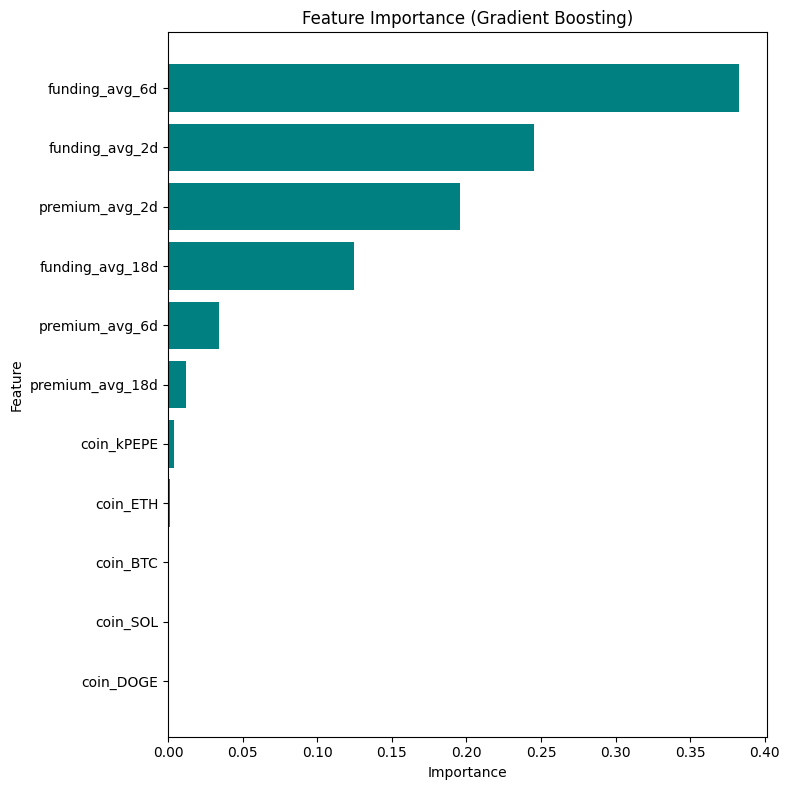

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Feature importance plot ---
importances = finalModel.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.barh(np.array(featureCols)[indices], importances[indices], color="teal")
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


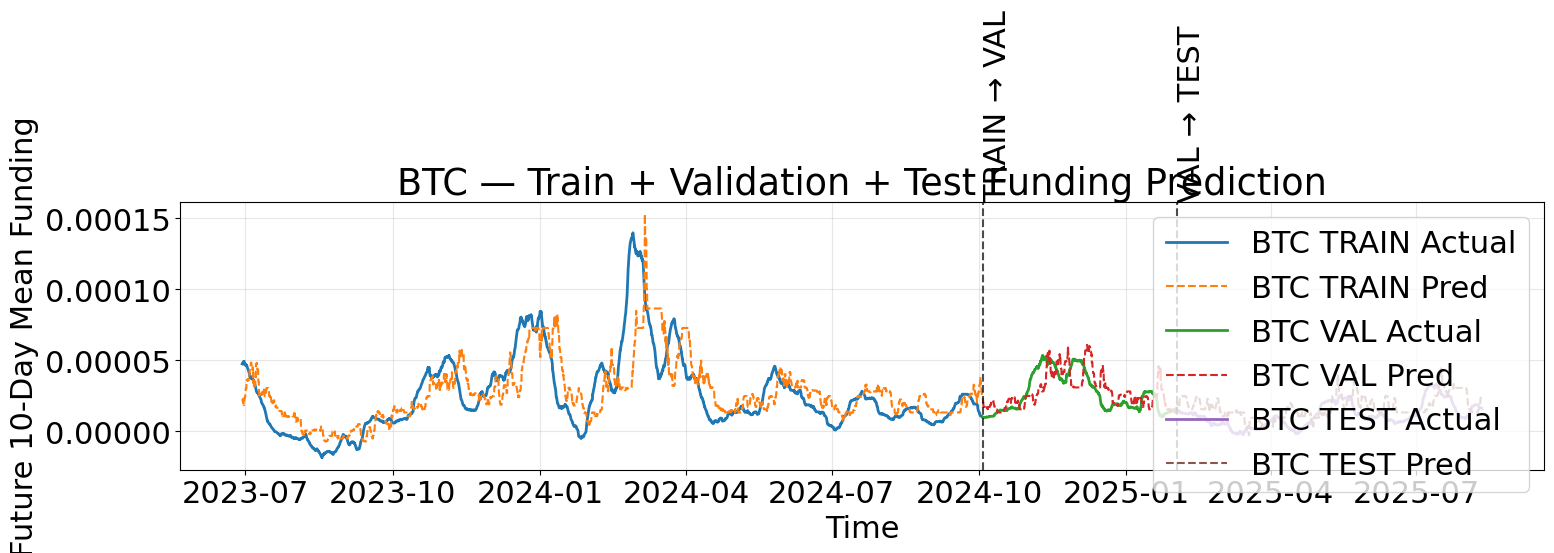

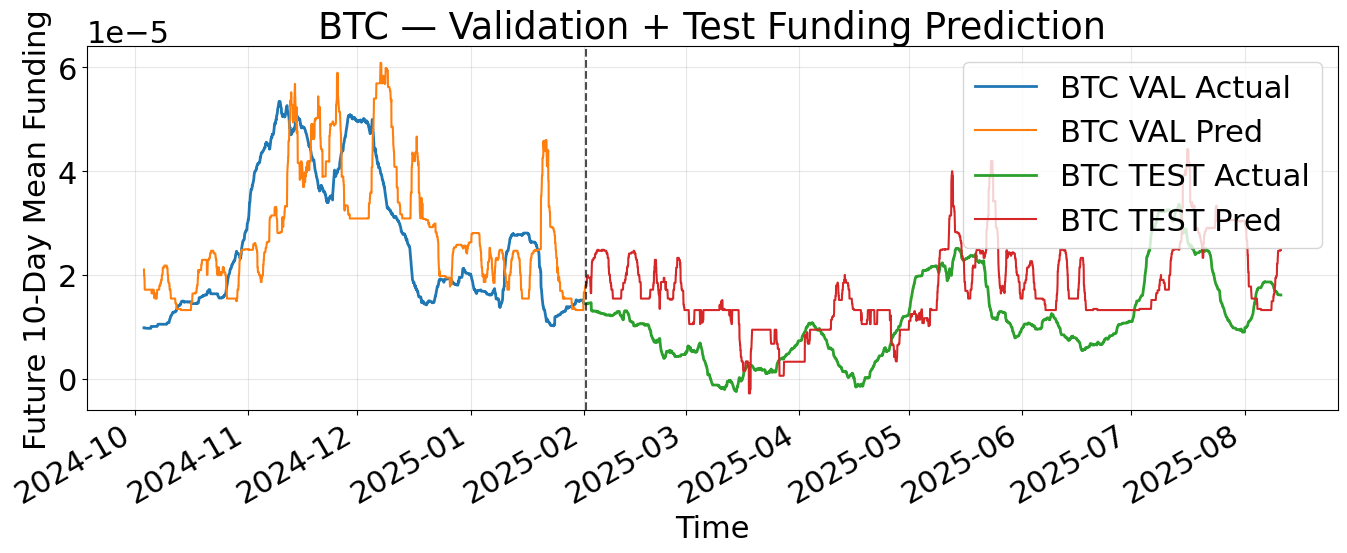

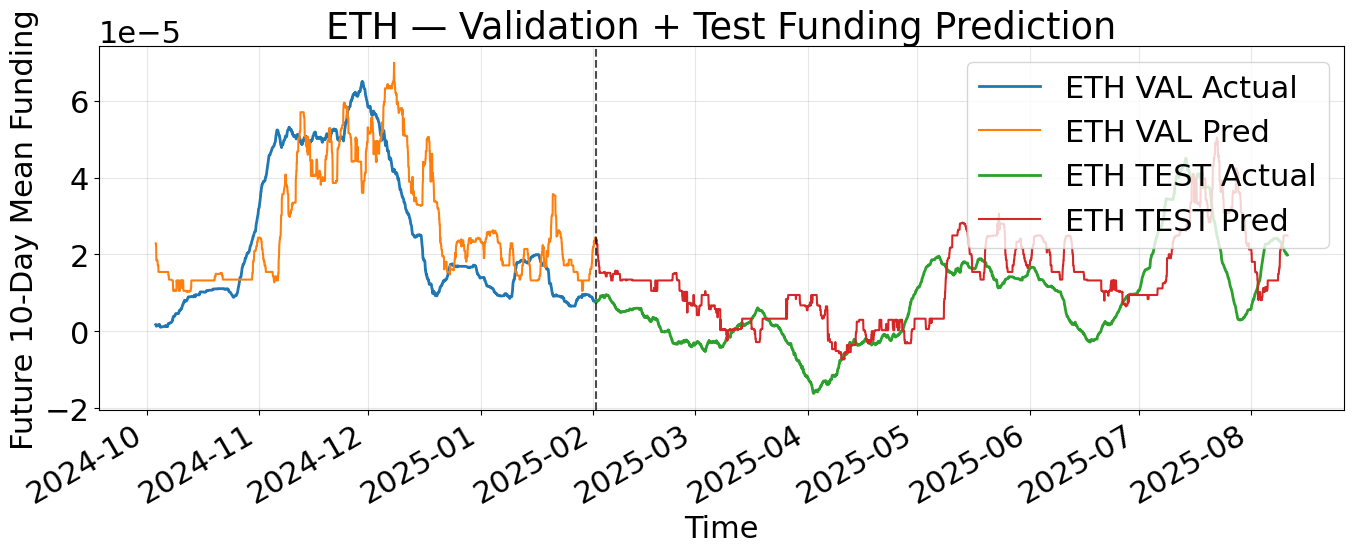

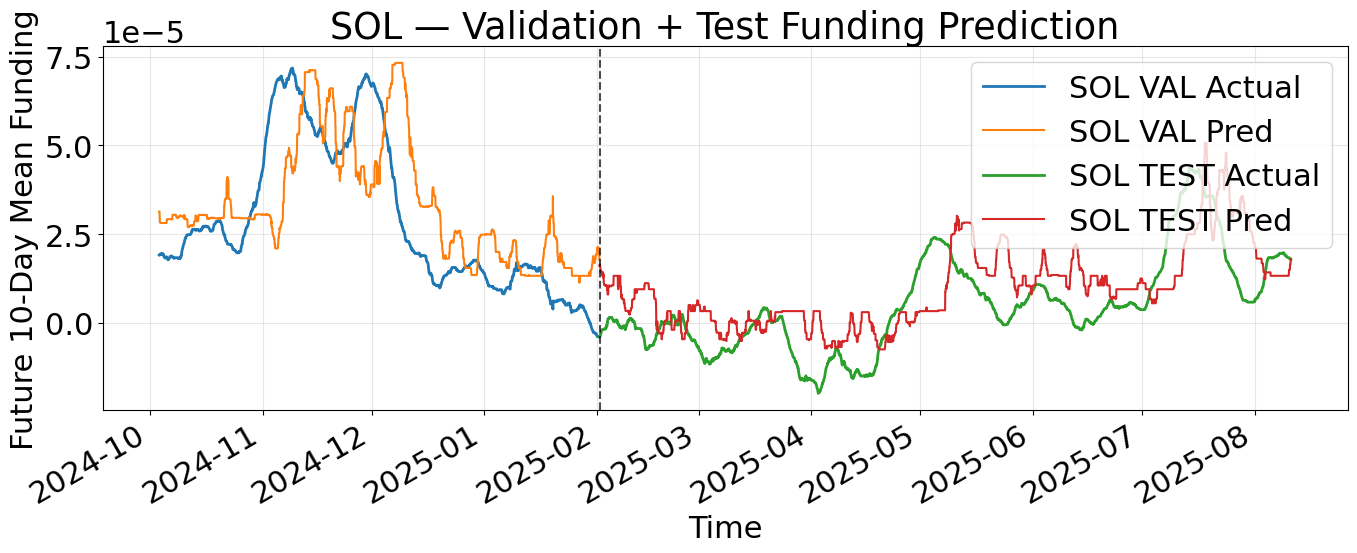

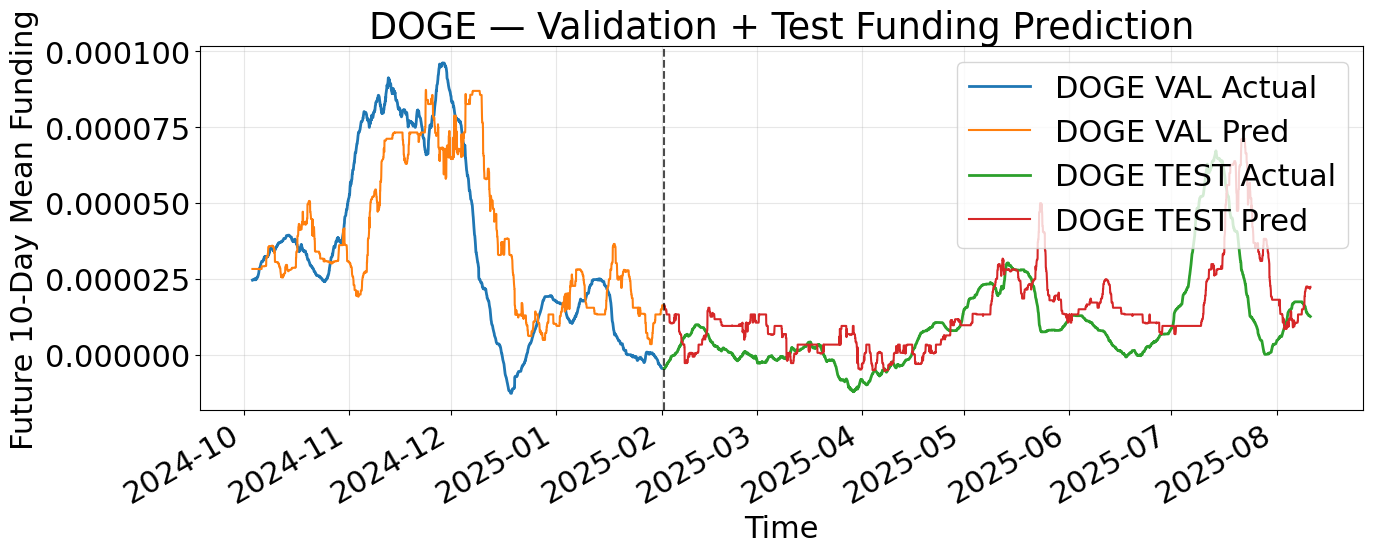

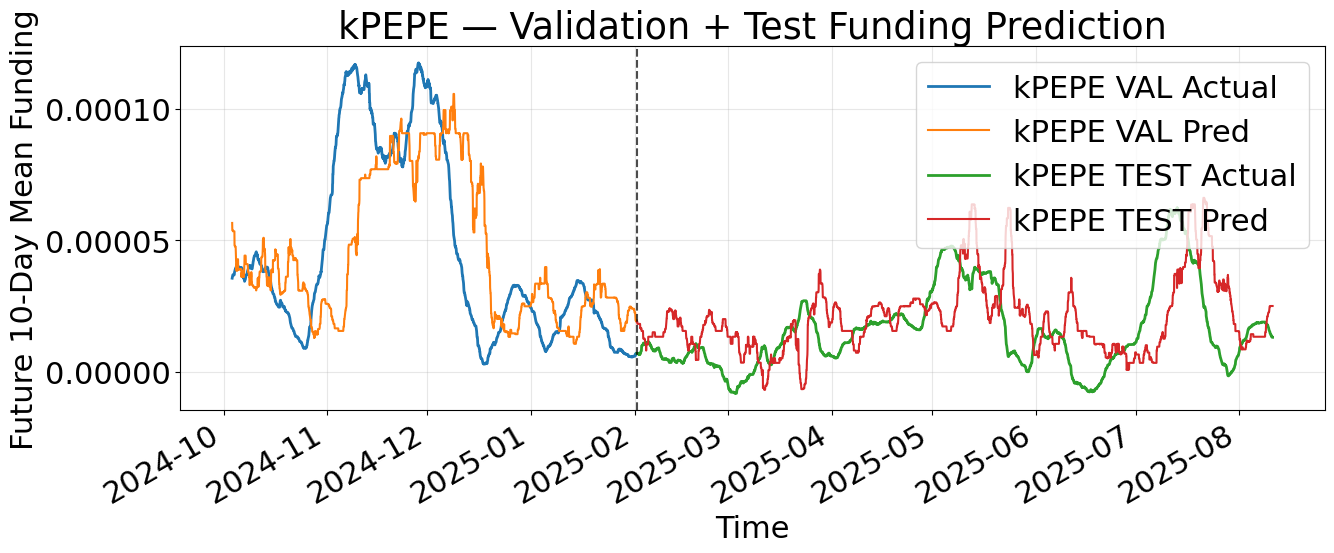

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 22

# =========================
# 1) BTC-only: TRAIN + VAL + TEST
# =========================
btcTrain = trainAll[trainAll["coin"] == "BTC"]
btcVal   = valAll[valAll["coin"] == "BTC"]
btcTest  = testAll[testAll["coin"] == "BTC"]

btcTrainPred = finalModel.predict(scalerFinal.transform(btcTrain[featureCols])) if len(btcTrain) else np.array([])
btcValPred   = finalModel.predict(scalerFinal.transform(btcVal[featureCols]))   if len(btcVal)   else np.array([])
btcTestPred  = finalModel.predict(scalerFinal.transform(btcTest[featureCols]))  if len(btcTest)  else np.array([])

dfBTC = pd.concat([btcTrain, btcVal, btcTest], ignore_index=True).copy()
dfBTC["yPred"] = np.r_[btcTrainPred, btcValPred, btcTestPred] if len(dfBTC) else np.array([])

fig, ax = plt.subplots(figsize=(16, 6))
if len(btcTrain):
    ax.plot(btcTrain["time"], btcTrain[targetCol], label="BTC TRAIN Actual", linewidth=2)
    ax.plot(btcTrain["time"], btcTrainPred, "--", label="BTC TRAIN Pred")
if len(btcVal):
    ax.plot(btcVal["time"], btcVal[targetCol], label="BTC VAL Actual", linewidth=2)
    ax.plot(btcVal["time"], btcValPred, "--", label="BTC VAL Pred")
    ax.axvline(btcVal["time"].iloc[0], color="black", linestyle="--", alpha=0.7)
    ax.text(btcVal["time"].iloc[0], ax.get_ylim()[1], "TRAIN → VAL", rotation=90, va="bottom")
if len(btcTest):
    ax.plot(btcTest["time"], btcTest[targetCol], label="BTC TEST Actual", linewidth=2)
    ax.plot(btcTest["time"], btcTestPred, "--", label="BTC TEST Pred")
    ax.axvline(btcTest["time"].iloc[0], color="black", linestyle="--", alpha=0.7)
    ax.text(btcTest["time"].iloc[0], ax.get_ylim()[1], "VAL → TEST", rotation=90, va="bottom")

ax.legend(loc="upper right")
ax.set_title("BTC — Train + Validation + Test Funding Prediction")
ax.set_xlabel("Time"); ax.set_ylabel("Future 10-Day Mean Funding")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

# =========================
# 2) Per-coin plots: VAL + TEST only
# =========================
coin_order = ["BTC", "ETH", "SOL", "DOGE", "kPEPE"]
for coin in coin_order:
    dfv = valAll[valAll["coin"] == coin]
    dft = testAll[testAll["coin"] == coin]

    yv_pred = finalModel.predict(scalerFinal.transform(dfv[featureCols])) if len(dfv) else np.array([])
    yt_pred = finalModel.predict(scalerFinal.transform(dft[featureCols])) if len(dft) else np.array([])

    fig, ax = plt.subplots(figsize=(14, 6))
    if len(dfv):
        ax.plot(dfv["time"], dfv[targetCol], label=f"{coin} VAL Actual", linewidth=2)
        ax.plot(dfv["time"], yv_pred, label=f"{coin} VAL Pred")
    if len(dft):
        ax.plot(dft["time"], dft[targetCol], label=f"{coin} TEST Actual", linewidth=2)
        ax.plot(dft["time"], yt_pred, label=f"{coin} TEST Pred")
        ax.axvline(dft["time"].iloc[0], color="black", linestyle="--", alpha=0.7)

    ax.legend(loc="upper right")
    ax.set_title(f"{coin} — Validation + Test Funding Prediction")
    ax.set_xlabel("Time"); ax.set_ylabel("Future 10-Day Mean Funding")
    ax.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show(block=True)


In [9]:
# --- Actual vs Predicted Funding for a Given Coin and Date (self-contained) ---
import numpy as np
import pandas as pd

# === configurable ===
coin_name  = "kPEPE"
target_date = "2025-04-01 00:00:00+00:00"
# ====================

# Build dfAll with predictions (uses trainAll/valAll/testAll, scalerFinal, finalModel, featureCols, targetCol)
def add_preds(df_part: pd.DataFrame) -> pd.DataFrame:
    if df_part.empty:
        return df_part.assign(yPred=np.array([], dtype=float))
    Xp = scalerFinal.transform(df_part[featureCols])
    yp = finalModel.predict(Xp)
    return df_part.assign(yPred=yp)

dfAll = pd.concat(
    [add_preds(trainAll), add_preds(valAll), add_preds(testAll)],
    ignore_index=True
).sort_values(["coin", "time"])

# Lookup actual vs predicted at/near target timestamp for the chosen coin
dfAll["time"] = pd.to_datetime(dfAll["time"], utc=True)
target_ts = pd.Timestamp(target_date)

coin_df = dfAll[dfAll["coin"] == coin_name].copy()
row = coin_df.loc[coin_df["time"] == target_ts, ["time", targetCol, "yPred"]]

actual_val = None
pred_val = None

if row.empty:
    same_day = coin_df[coin_df["time"].dt.date == target_ts.date()] \
        .sort_values("time")[["time", targetCol, "yPred"]]
    if same_day.empty:
        coin_df["abs_diff"] = (coin_df["time"] - target_ts).abs()
        nearest = coin_df.nsmallest(3, "abs_diff")[["time", targetCol, "yPred"]]
        print(f"No {coin_name} row at {target_date} — nearest rows:")
        print(nearest.rename(columns={targetCol: "actual_10d_mean", "yPred": "pred_10d_mean"}))
        actual_val = float(nearest[targetCol].iloc[0])
        pred_val   = float(nearest["yPred"].iloc[0])
    else:
        print(f"{coin_name} rows on {target_ts.date()} (UTC):")
        print(same_day.rename(columns={targetCol: "actual_10d_mean", "yPred": "pred_10d_mean"}))
        actual_val = float(same_day[targetCol].iloc[0])
        pred_val   = float(same_day["yPred"].iloc[0])
else:
    print(f"{coin_name} @ {target_date} (UTC):")
    print(row.rename(columns={targetCol: "actual_10d_mean", "yPred": "pred_10d_mean"}))
    actual_val = float(row[targetCol].iloc[0])
    pred_val   = float(row["yPred"].iloc[0])

# Approx annualized yield
if actual_val is not None and pred_val is not None:
    actual_yield = actual_val * 365 * 24 * 100
    pred_yield   = pred_val   * 365 * 24 * 100
    print(f"\nApprox annualized yield ({coin_name}, actual)   = {actual_yield:.2f}% per year")
    print(f"Approx annualized yield ({coin_name}, predicted) = {pred_yield:.2f}% per year")


kPEPE @ 2025-04-01 00:00:00+00:00 (UTC):
                           time  actual_10d_mean  pred_10d_mean
75468 2025-04-01 00:00:00+00:00         0.000006       0.000019

Approx annualized yield (kPEPE, actual)   = 5.08% per year
Approx annualized yield (kPEPE, predicted) = 16.33% per year


Summary: {'total_blocks': 20, 'total_realized_240h_sum': 0.050434962566666665, 'avg_realized_per_block': 0.0025217481283333334, 'annualized_estimate': 0.09204380668416667, 'k': 3, 'horizon_hours': 240, 'step_hours': 240, 'compound': False, 'equity_end': 1.0, 'fee': 0.00115}

ALL BLOCKS:
            decision_time               block_start                 block_end  n_picks     picked_coins         entries  block_pred_total_ew  block_realized_total_ew  gross_pred_total_240h  gross_realized_total_240h  fee_entries  cum_realized_total_240h  equity
2025-02-01 17:00:00+00:00 2025-02-01 17:00:00+00:00 2025-02-11 17:00:00+00:00        3  ETH, kPEPE, BTC BTC, ETH, kPEPE             0.003678                 0.001167               0.004828                   0.002317     0.001150                 0.001167     1.0
2025-02-11 17:00:00+00:00 2025-02-11 17:00:00+00:00 2025-02-21 17:00:00+00:00        3  kPEPE, BTC, ETH                             0.004296                 0.001655               0.004296

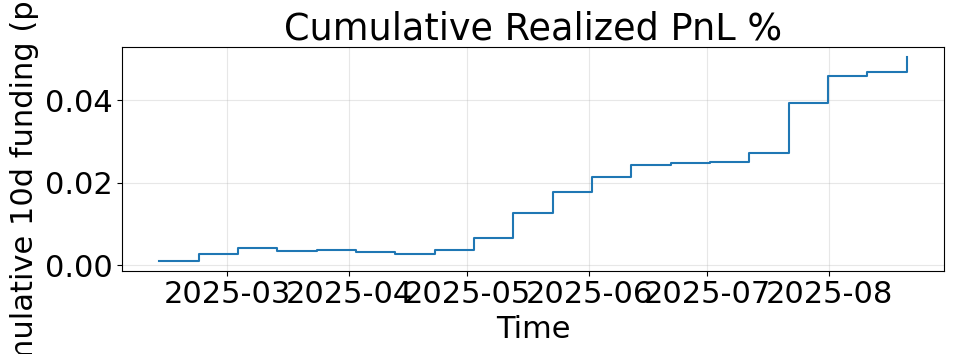

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_datetime64_any_dtype, is_datetime64tz_dtype

def backtest_topk_funding(
    testAll: pd.DataFrame,
    featureCols: list,
    targetCol: str,            # realized next-10d mean funding
    finalModel,
    scalerFinal,
    k: int = 3,
    horizon_hours: int = 240,  # 10 days * 24h
    step_hours: int = 240,     # rebalance every 10 days
    min_k_enforced: bool = True,   # require >=k coins at a decision time
    fee: float = 0.00115,  # 0.0575% per entry (no fee if coin held from prior block)
    compound: bool = False          # if True, compound; else sum linearly
):
    # --- prep ---
    df = testAll.copy()

    # robust datetime handling (works for tz-naive or tz-aware, normalizes to UTC)
    if not (is_datetime64_any_dtype(df["time"]) or is_datetime64tz_dtype(df["time"])):
        df["time"] = pd.to_datetime(df["time"], utc=True)
    else:
        df["time"] = pd.to_datetime(df["time"], utc=True)

    # drop rows missing features/target; sort
    df = df.dropna(subset=featureCols + [targetCol]).sort_values(["time", "coin"]).reset_index(drop=True)

    # predictions
    X = scalerFinal.transform(df[featureCols])
    df["yPred"] = finalModel.predict(X)

    # unique decision times as a DatetimeIndex (avoids tz dtype issues)
    decision_times = pd.DatetimeIndex(df["time"].unique()).sort_values()

    blocks = []
    picks_rows = []
    idx = 0
    cum_total = 0.0
    equity = 1.0  # start NAV for compounding
    prev_picks = set()  # for turnover-aware fees

    while idx < len(decision_times):
        t = decision_times[idx]

        # rows at decision time t
        slice_t = df[df["time"] == t]
        if slice_t.empty:
            idx += 1
            continue

        # ensure enough candidates if required
        if min_k_enforced and len(slice_t) < k:
            next_t = t + pd.Timedelta(hours=step_hours)
            idx = decision_times.searchsorted(next_t, side="left")
            continue

        # top-k by prediction
        topk = slice_t.nlargest(min(k, len(slice_t)), "yPred").copy()

        # realized & predicted totals over the 240h block
        topk["realized_total_240h"]  = topk[targetCol] * horizon_hours
        topk["predicted_total_240h"] = topk["yPred"]    * horizon_hours
        topk["rank"] = np.arange(1, len(topk) + 1)

        # ----- ENTRY-ONLY FEES -----
        current_picks = set(topk["coin"])
        entries = current_picks - prev_picks   # coins newly added this block
        w = 1.0 / max(1, len(topk))            # equal weight per selected coin
        fee_entries = len(entries) * fee * w  # per-$1 notional

        # net block PnL after entry-only fees
        block_realized_gross = float(topk["realized_total_240h"].mean())
        block_pred_gross     = float(topk["predicted_total_240h"].mean())
        block_realized = block_realized_gross - fee_entries
        block_pred     = block_pred_gross     - fee_entries

        # PnL update
        if compound:
            equity *= (1.0 + block_realized)
            cum_total = equity - 1.0
        else:
            cum_total += block_realized

        # record picks
        for _, r in topk.iterrows():
            picks_rows.append({
                "decision_time": t,
                "coin": r["coin"],
                "rank": int(r["rank"]),
                "yPred": float(r["yPred"]),
                "pred_total_240h": float(r["predicted_total_240h"]),
                "actual_mean_10d": float(r[targetCol]),
                "realized_total_240h": float(r["realized_total_240h"]),
            })

        # record block summary (stamp PnL at block end)
        blocks.append({
            "decision_time": t,                           # block start (for reference)
            "block_start": t,
            "block_end": t + pd.Timedelta(hours=step_hours),
            "n_picks": int(len(topk)),
            "picked_coins": ", ".join(topk["coin"].tolist()),
            "entries": ", ".join(sorted(entries)) if entries else "",
            "block_pred_total_ew": block_pred,
            "block_realized_total_ew": block_realized,
            "gross_pred_total_240h": block_pred_gross,
            "gross_realized_total_240h": block_realized_gross,
            "fee_entries": float(fee_entries),
            "cum_realized_total_240h": float(cum_total),
            "equity": float(equity),
        })

        prev_picks = current_picks
        # advance to next decision time >= t + step_hours
        next_t = t + pd.Timedelta(hours=step_hours)
        idx = decision_times.searchsorted(next_t, side="left")

    blocks_df = pd.DataFrame(blocks)
    picks_df  = pd.DataFrame(picks_rows)

    # summary stats
    total_blocks = len(blocks_df)
    total_realized = float(blocks_df["block_realized_total_ew"].sum()) if total_blocks else 0.0
    avg_per_block = total_realized / total_blocks if total_blocks else 0.0
    blocks_per_year = 365.0 / (horizon_hours / 24.0)
    annualized_est = avg_per_block * blocks_per_year if total_blocks else 0.0
    equity_end = float(blocks_df["equity"].iloc[-1]) if total_blocks else 1.0

    summary = {
        "total_blocks": total_blocks,
        "total_realized_240h_sum": total_realized,
        "avg_realized_per_block": avg_per_block,
        "annualized_estimate": annualized_est,
        "k": k,
        "horizon_hours": horizon_hours,
        "step_hours": step_hours,
        "compound": compound,
        "equity_end": equity_end,
        "fee": fee
    }

    return blocks_df, picks_df, summary


# ---- Example usage ----
# Requires: testAll, featureCols, targetCol, finalModel, scalerFinal in scope.
blocks_df, picks_df, summary = backtest_topk_funding(
    testAll=testAll,
    featureCols=featureCols,
    targetCol=targetCol,
    finalModel=finalModel,
    scalerFinal=scalerFinal,
    k=3,
    horizon_hours=240,
    step_hours=240,
    min_k_enforced=True,
    fee=0.00115,     # <-- your fee here
    compound=False
)

print("Summary:", summary)

# Print ALL blocks and ALL picks (no truncation)
with pd.option_context(
    "display.max_rows", None,
    "display.max_columns", None,
    "display.width", 0,
    "display.max_colwidth", None
):
    print("\nALL BLOCKS:")
    print(blocks_df.to_string(index=False))

    print("\nALL PICKS:")
    print(picks_df.to_string(index=False))

# Save full tables too
blocks_df.to_csv("blocks_full.csv", index=False)
picks_df.to_csv("picks_full.csv", index=False)

# Plot (PnL stamped at block end)
plt.figure(figsize=(10,4))
plt.step(blocks_df["block_end"], blocks_df["cum_realized_total_240h"], where="post", linewidth=1.5)
plt.title("Cumulative Realized PnL %")
plt.xlabel("Time"); plt.ylabel("Cumulative 10d funding (per $1)")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()
